In [9]:
import numpy as np
import tensorflow as tf
import binvox_rw
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


In [10]:
def center(voxin):
    f = np.squeeze(np.max(voxin, axis=(2, 1)))
    s = np.squeeze(np.max(voxin, axis=(2, 0)))
    t = np.squeeze(np.max(voxin, axis=(1, 0)))

    nzf = np.sum(f == 0) 
    nzs = np.sum(s == 0)
    nzt = np.sum(t == 0)

    i_f = np.argmax(f)
    l_f = np.sum(f > 0)
    i_s = np.argmax(s)
    l_s = np.sum(s > 0)
    i_t = np.argmax(t)
    l_t = np.sum(t > 0)

    zfl = np.floor(nzf/2.0).astype(int)
    zfr = nzf - zfl
    zsl = np.floor(nzs/2.0).astype(int)
    zsr = nzs - zsl
    ztl = np.floor(nzt/2.0).astype(int)
    ztr = nzt - ztl  

    voxout = np.zeros_like(voxin)
    voxout[zfl:128-zfr, zsl:128-zsr, ztl:128-ztr] = voxin[i_f:i_f+l_f, i_s:i_s+l_s, i_t:i_t+l_t,]
    return voxout

In [31]:
class voxel_gen(Sequence):
    def __init__(self, x_set,y_set,batch_size=32, dim_image=(512,512,3),dim_voxel=(128,128,128)):
        self.x = x_set # path for each dataset : models/models-binvox-solid
        self.y = y_set
        self.batch_size = batch_size
        self.dim_voxel = dim_voxel
        self.dim_image = dim_image

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        y_set_temp = self.y[index*self.batch_size:(index+1)*self.batch_size]
        x_set_temp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        X,Y = self.__data_generation(x_set_temp,y_set_temp)
        return (X,Y)
    
    def __data_generation(self,x_set_temp,y_set_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X0 = np.empty((self.batch_size, *self.dim_image))
        X1 = np.empty((self.batch_size, *self.dim_image))
        X2 = np.empty((self.batch_size, *self.dim_image))
        X3 = np.empty((self.batch_size, *self.dim_image))
        Y = np.empty((self.batch_size, *self.dim_voxel, 1))

        for i in range(len(x_set_temp)):
            view0="models/models-screenshots/view0/data"+"/"+f"{i+1:05d}"+"-00.png"
            view1="models/models-screenshots/view1/data"+"/"+f"{i+1:05d}"+"-01.png"
            view2="models/models-screenshots/view2/data"+"/"+f"{i+1:05d}"+"-02.png"
            view3="models/models-screenshots/view3/data"+"/"+f"{i+1:05d}"+"-03.png"
            X0[i,]=np.array(Image.open(view0))[:,:,0:3]/255.
            X1[i,]=np.array(Image.open(view1))[:,:,0:3]/255.
            X2[i,]=np.array(Image.open(view2))[:,:,0:3]/255.
            X3[i,]=np.array(Image.open(view3))[:,:,0:3]/255.
            with open(str(y_set_temp[i]), 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            Y[i,] = np.expand_dims(model.data, axis=-1)
    
        return ((X0,X1,X2,X3),Y)

In [32]:
def customGen(batch_size=32):
    
    
    voxels = Path("models/models-binvox-solid/data")
    fvoxels = [f for f in voxels.iterdir() if f.is_file()]
    
    out = voxel_gen(fvoxels,fvoxels, batch_size)
    while True:
        for x, y in out:
            yield (x,y)

In [33]:
gen1 = customGen(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3)
00001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


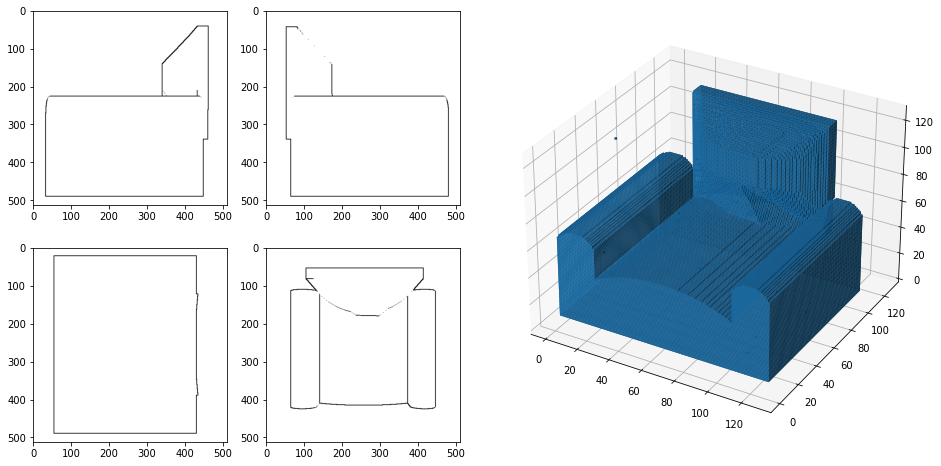

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3)
00002


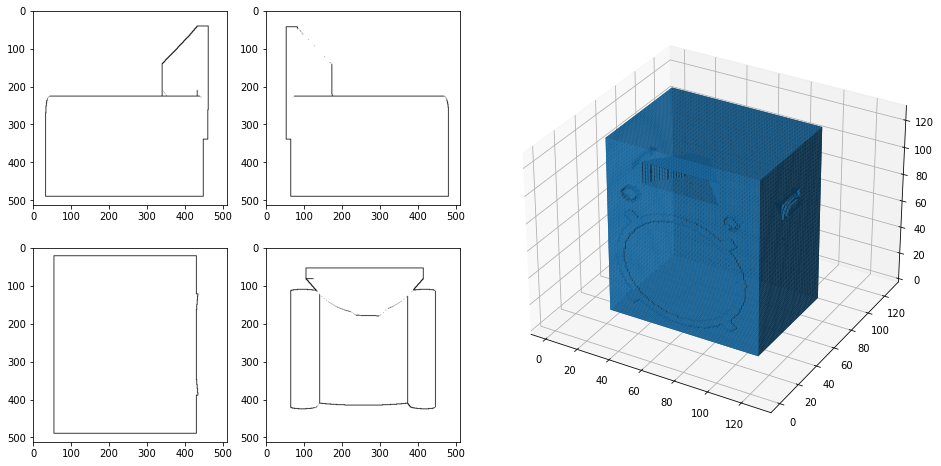

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3)
00003


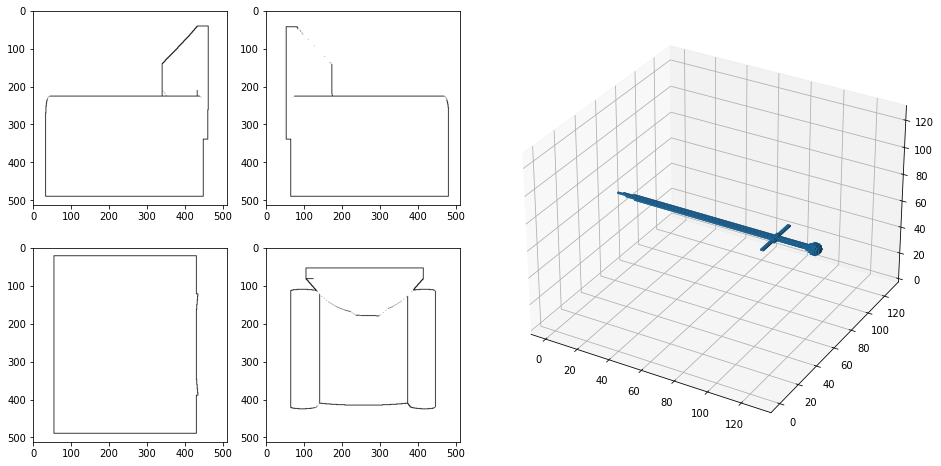

In [34]:
voxels = Path("models/models-binvox-solid/data")
fvoxels = [f for f in voxels.iterdir() if f.is_file()]
count = -1
for X, y in gen1:
    count += 1 
    if count<3:
        print(X[0].shape,X[1].shape,X[2].shape,X[3].shape)
        print(fvoxels[count].stem)
        fig = plt.figure(figsize=(16, 8))
        ax1 = plt.subplot2grid((2, 4), (0, 0))
        ax2 = plt.subplot2grid((2, 4), (0, 1))
        ax3 = plt.subplot2grid((2, 4), (1, 0))
        ax4 = plt.subplot2grid((2, 4), (1, 1))
        ax5 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2, projection='3d')
        y = center(np.squeeze(y))
        ax1.imshow(np.squeeze(X[0]))
        ax2.imshow(np.squeeze(X[1]))
        ax3.imshow(np.squeeze(X[2]))
        ax4.imshow(np.squeeze(X[3]))
        ax5.voxels(np.squeeze(y))
        plt.show()
    else:
        break

In [ ]:
import skimage.measure
from skimage.measure import block_reduce
voxels = Path("models/models-binvox-solid/data/00001.binvox")
with open(voxels, 'rb') as f:
    model = binvox_rw.read_as_3d_array(f)
# model.dims 
#model.data
image=(np.array(model.data))*1
print(image.shape)
#.reshape(model.dims)+0
k=skimage.measure.block_reduce(image, (2,2,2), np.max)
print(k.shape)

In [ ]:
depth = 30
height = 30
width = 30
input_channels = 3

inputs = tf.keras.Input(shape=(depth, height, width, input_channels))
layer = tf.keras.layers.MaxPooling3D(pool_size=3)
outputs = layer(inputs)  # Shape: (batch_size, 10, 10, 10, 3)

In [ ]:
def image():
    for i in range(1,11695):
        view0="models/models-screenshots/view0/data"+"/"+f"{i:05d}"+"-00.png"
        view1="models/models-screenshots/view1/data"+"/"+f"{i:05d}"+"-01.png"
        view2="models/models-screenshots/view2/data"+"/"+f"{i:05d}"+"-02.png"
        view3="models/models-screenshots/view3/data"+"/"+f"{i:05d}"+"-03.png"
        view4="models/models-screenshots/view4/data"+"/"+f"{i:05d}"+"-04.png"
        view5="models/models-screenshots/view5/data"+"/"+f"{i:05d}"+"-05.png"
        view6="models/models-screenshots/view6/data"+"/"+f"{i:05d}"+"-06.png"
        view7="models/models-screenshots/view7/data"+"/"+f"{i:05d}"+"-07.png"
        view8="models/models-screenshots/view8/data"+"/"+f"{i:05d}"+"-08.png"
        view9="models/models-screenshots/view9/data"+"/"+f"{i:05d}"+"-09.png"
        view10="models/models-screenshots/view10/data"+"/"+f"{i:05d}"+"-10.png"
        view11="models/models-screenshots/view11/data"+"/"+f"{i:05d}"+"-11.png"
        view12="models/models-screenshots/view12/data"+"/"+f"{i:05d}"+"-12.png"
        view13="models/models-screenshots/view13/data"+"/"+f"{i:05d}"+"-13.png"
        view14="models/models-screenshots/view14/data"+"/"+f"{i:05d}"+"-14.png"
        
        yield (view0,view1,view2,view3,view4,view5,view6,view7,view8,view9,view10,view11,view12,view13,view14)

In [ ]:
n=image()
n.__next__()    

In [ ]:
n.__next__()

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


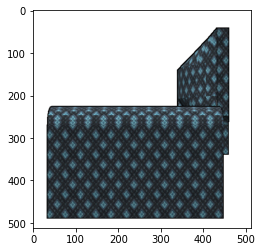

In [6]:
v=cv2.imread('models/models-screenshots/view0/data/00001-00.png')/255.
print(v)
plt.imshow(v)
plt.show()